Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from autocorrect import Speller
import matplotlib.pyplot as plt
import seaborn as sns
spell = Speller(lang='en')

Confusion Matrix

In [2]:
def confusion(y, predicted):
    conf_matrix = confusion_matrix(y, predicted)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                cmap="Blues")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

## Importing the data


In [3]:
df = pd.read_csv('train.csv', encoding='utf-8')
df_test = pd.read_csv('test.csv', encoding='utf-8')
submission = pd.read_csv('submission.csv', encoding='utf-8')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

The data is not skewed so we're good to go.

Printing random tweets to check how the text looks like and their target

In [5]:
x = np.random.randint(df.shape[0])
print("{}. Target is '{}'".format(df.iloc[x]['text'], df.iloc[x]['target']))

@abran_caballero Discovered by @NickCannon 
 Listen/Buy @realmandyrain #RIOT on @iTunesMusic @iTunes https://t.co/dehMym5lpk Û_ #BlowMandyUp. Target is '0'


# Cleaning the Tweets


In [6]:
# Removing hashtags
regex = r'[#|@]\w+'
df['cleaned_text'] = df['text'].str.replace(regex, "")
# remove urls
regex = r'http\S+'
df['cleaned_text'] = df['cleaned_text'].str.replace(regex, "")
# remove html tags
regex = '[^\w\s]|_'
df['cleaned_text'] = df['cleaned_text'].str.replace(regex, " ")
# removing next line characters
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', '')
# Lower case all the text
df['cleaned_text'] = df['cleaned_text'].str.lower()
# Keeping only words which are greater than two characters
df['cleaned_text'] = df['cleaned_text'].str.findall('\w{3,}').str.join(' ')
"""
<------------------------------------------------------------------------------------------------------------->
"""
# Same for the test case
regex = r'[#|@]\w+'
df_test['cleaned_text'] = df_test['text'].str.replace(regex, "")
regex = r'http\S+'
df_test['cleaned_text'] = df_test['cleaned_text'].str.replace(regex, "")
regex = '[^\w\s]|_'
df_test['cleaned_text'] = df_test['cleaned_text'].str.replace(regex, " ")
df_test['cleaned_text'] = df_test['cleaned_text'].str.replace('\n', '')
df_test['cleaned_text'] = df_test['cleaned_text'].str.lower()
df_test['cleaned_text'] = df_test['cleaned_text'].str.findall('\w{3,}').str.join(' ')

Removing stop words

In [7]:
stop_words = list(stopwords.words('english'))

In [8]:
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['cleaned_text'] = df['cleaned_text'].str.replace(regex_stopword, "")
    df_test['cleaned_text'] = df_test['cleaned_text'].str.replace(regex_stopword, "")

Remove excessive spaces between characters

In [9]:
df['space'] = df['cleaned_text'].str.split(' +')
df['cleaned_text'] = df['space'].apply(' '.join)

df_test['space'] = df_test['cleaned_text'].str.split(' +')
df_test['cleaned_text'] = df_test['space'].apply(' '.join)

Now we can check how the cleaned tweets look

In [10]:
x = np.random.randint(df.shape[0])
print("{} \n {}".format(df.iloc[x]['text'], df.iloc[x]['cleaned_text']))

If you can't have the roar of the waves a rainstorm &amp; some rollingÛ_ https://t.co/DlVYFvnQee 
  roar waves rainstorm amp rolling


## Stemming & Lemmetising

In [11]:
stemmer = nltk.stem.PorterStemmer()
df['Porter_stemmed'] = df['cleaned_text'].apply(lambda x: ' '.join(stemmer.stem(y) for y in x.split()))
df_test['Porter_stemmed'] = df_test['cleaned_text'].apply(lambda x: ' '.join(stemmer.stem(y) for y in x.split()))

In [12]:
df['Lemmatized'] = df['cleaned_text'].apply(lambda x: ' '.join(WordNetLemmatizer().lemmatize(word, pos="v") for word in x.split()))
df_test['Lemmatized'] = df_test['cleaned_text'].apply(lambda x: ' '.join(WordNetLemmatizer().lemmatize(word, pos="v") for word in x.split()))

In [13]:
x = np.random.randint(df.shape[0])
print("Cleaned tweet : {}\nPorter Stemming : {}\nLemmatizing : {}".format(df.iloc[x]['cleaned_text'], df.iloc[x]['Porter_stemmed'], df.iloc[x]['Lemmatized']))

Cleaned tweet : aubrey really body bagging meek
Porter Stemming : aubrey realli bodi bag meek
Lemmatizing : aubrey really body bag meek


## Transforming data into vectors

In [14]:
y_test = submission['target']
y_train = df['target']
X_test = df_test['Porter_stemmed']

### Using Multinomial Naive Bayes Model

We use TfidfVectoriser with ngram_range and build a vocabulary that only consider the top 5000 ordered by term frequency across the corpus with a min frequency of ocurrence 3

In [15]:
ngram_range = (1,3)
vectorizer = TfidfVectorizer(ngram_range=ngram_range,
                            max_features=10000,
                            min_df = 2)
X_tfidf = vectorizer.fit_transform(df['Porter_stemmed'])

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

clfNB = MultinomialNB(alpha=0.05).fit(X_tfidf, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clfNB.predict(X_tfidf))))
print("Test accuracy : {}".format(accuracy_score(y_test, clfNB.predict(vectorizer.transform(X_test)))))

Train accuracy : 0.871929594115329
Test accuracy : 0.7839411584431505


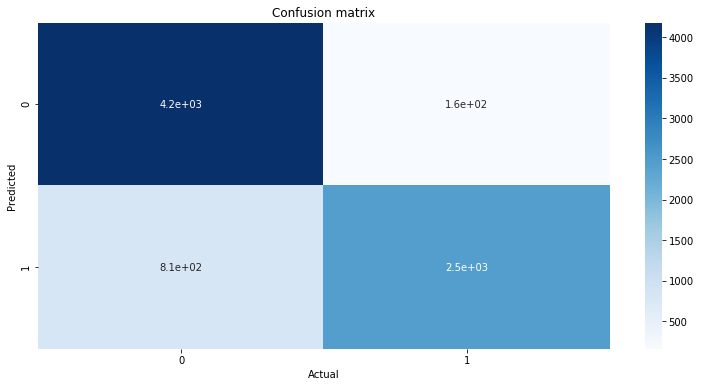

In [17]:
confusion(y_train, clfNB.predict(X_tfidf))

In [18]:
mnbc_pred = clfNB.predict(vectorizer.transform(X_test))
print(classification_report(y_test, mnbc_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1861
           1       0.83      0.62      0.71      1402

    accuracy                           0.78      3263
   macro avg       0.80      0.76      0.77      3263
weighted avg       0.79      0.78      0.78      3263



Using CountVectorizer as a feature extractor

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer()
vect = vectoriser.fit(df['Porter_stemmed'])

In [20]:
X_count = vect.transform(df['Porter_stemmed'])

In [21]:
clfNB = MultinomialNB(alpha=0.1).fit(X_count, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clfNB.predict(X_count))))
print("Test accuracy : {}".format(accuracy_score(y_test, clfNB.predict(vect.transform(X_test)))))

Train accuracy : 0.9134375410482071
Test accuracy : 0.7744406987434876


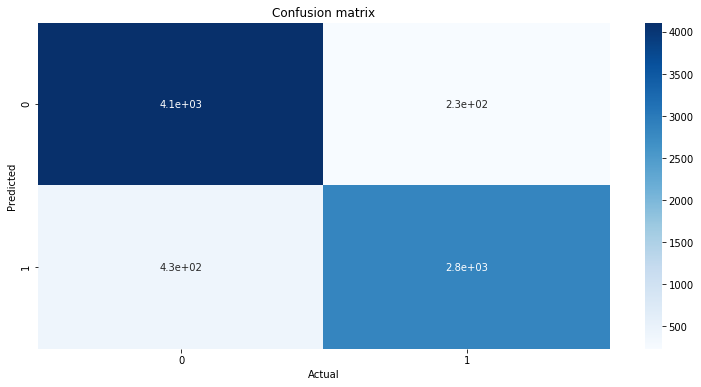

In [22]:
confusion(y_train, clfNB.predict(X_count))

In [23]:
mnbc_pred = clfNB.predict(vect.transform(X_test))
print(classification_report(y_test,mnbc_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1861
           1       0.76      0.69      0.72      1402

    accuracy                           0.77      3263
   macro avg       0.77      0.76      0.77      3263
weighted avg       0.77      0.77      0.77      3263



We try a few other models

### Using KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

In [25]:
# For Tfidf vectors
neigh.fit(X_tfidf, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, neigh.predict(X_tfidf))))
print("Test accuracy : {}".format(accuracy_score(y_test, neigh.predict(vectorizer.transform(X_test)))))

Train accuracy : 0.7756469197425456
Test accuracy : 0.6628869138829299


In [26]:
# For CountVectoriser vectors
neigh.fit(X_count, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, neigh.predict(X_count))))
print("Test accuracy : {}".format(accuracy_score(y_test, neigh.predict(vect.transform(X_test)))))

Train accuracy : 0.7186391698410614
Test accuracy : 0.6135458167330677


### SVM classifier

We check the classifier for linear and rbf kernels

In [27]:
from sklearn import svm

In [28]:
# For Tfidf vectors
clf = svm.SVC(kernel='linear')
clf.fit(X_tfidf, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clf.predict(X_tfidf))))
print("Test accuracy : {}".format(accuracy_score(y_test, clf.predict(vectorizer.transform(X_test)))))

Train accuracy : 0.8907132536450808
Test accuracy : 0.7775053631627337


In [29]:
# For Tfidf vectors
clf = svm.SVC(kernel='rbf')
clf.fit(X_tfidf, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clf.predict(X_tfidf))))
print("Test accuracy : {}".format(accuracy_score(y_test, clf.predict(vectorizer.transform(X_test)))))

Train accuracy : 0.9460133981347695
Test accuracy : 0.7946674839105118


In [30]:
# For CountVectoriser vectors
clf = svm.SVC(kernel='linear')
clf.fit(X_count, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clf.predict(X_count))))
print("Test accuracy : {}".format(accuracy_score(y_test, clf.predict(vect.transform(X_test)))))

Train accuracy : 0.9607250755287009
Test accuracy : 0.7704566349984676


In [31]:
# For CountVectoriser vectors
clf = svm.SVC(kernel='rbf')
clf.fit(X_count, y_train)
print("Train accuracy : {}".format(accuracy_score(y_train, clf.predict(X_count))))
print("Test accuracy : {}".format(accuracy_score(y_test, clf.predict(vect.transform(X_test)))))

Train accuracy : 0.9349796400893209
Test accuracy : 0.7955868832362857


We have used Porter stemmer as our stemming in above cases